In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots  import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio
import plotly.express as px
pio.renderers.default = 'iframe'

import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx 
import itertools
from itertools import combinations
import random
import re
from collections import Counter
import os
import ast

# NLP
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
from textblob import TextBlob
import nltk.sentiment.vader as vd
from nltk import download
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')
# download('vader_lexicon')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None) # To show the whole description of titles

import utils as u

colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

### Load the data

In [2]:
titles = pd.read_csv("Titles.csv")
titles = titles[~titles["title"].isnull()]

titles['seasons'].fillna(0,inplace=True)
titles['imdb_score'].fillna(0,inplace=True)
titles['tmdb_popularity'].fillna(0,inplace=True)


credits = pd.read_csv("Credits.csv")
df = pd.merge(titles,credits, on='id', how='left')

In [3]:
titles.shape, credits.shape, df.shape

((5805, 15), (77213, 5), (77584, 19))

In [4]:
fig = px.bar(u.missing_values(df).reset_index(), x="column_name", y="missing_values(%)", title="Missing Values")
fig.show()

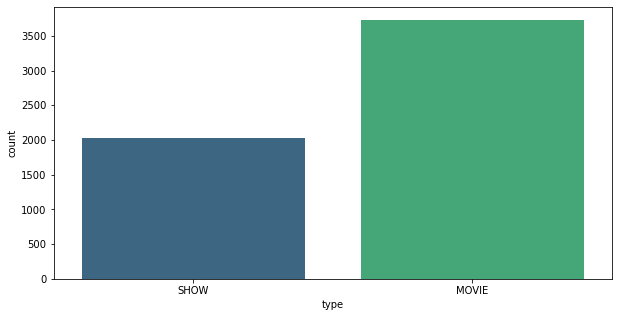

In [5]:
a,ax=plt.subplots(figsize=(10,5))
sns.countplot(data=df.drop_duplicates(subset='title'), x="type",palette="viridis",ax=ax)
plt.show()

In [6]:
df.head(2)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,person_id,name,character,role
0,ts300399,Five Came Back: The Reference Films,SHOW,"This collection includes 12 World War II-era propaganda films — many of which are graphic and offensive — discussed in the docuseries ""Five Came Back.""",1945,TV-MA,48,['documentation'],['US'],1.0,NaN,0.0,NaN,0.600,NaN,NaN,NaN,NaN,NaN
1,tm84618,Taxi Driver,MOVIE,"A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action, attempting to save a preadolescent prostitute in the process.",1976,R,113,"['crime', 'drama']",['US'],0.0,tt0075314,8.3,795222.0,27.612,8.2,3748.0,Robert De Niro,Travis Bickle,ACTOR


# Pre-Processing

In [5]:
df['rating']=df['age_certification'].replace({
    'PG-13':'Teens - Age above 12',
    'TV-MA' :'Adults',
    'PG' : 'Kids - with parental guidance',
    'TV-14':'Teens Age above age of 14',
    'TV-PG':'Kids-with parental guidance',
    'TV-Y':'Kids',
    'TV-Y7': 'Kids-Age above 7',
    'R': 'Adults',
    'TV-G':'Kids',
    'NC-17': 'Adults',
    'NR': 'NR',
    'UR': 'UR',
})

df['imdb_score'].fillna(0, inplace=True)
df["production_countries"]=df["production_countries"].apply(u.repair_array_bound_categories)
df = df.explode('production_countries').drop_duplicates()


# df["genres"]=df["genres"].apply(u.repair_array_bound_categories)
# df = df.explode('genres').drop_duplicates()

In [6]:
titles["genres"]=titles["genres"].apply(u.repair_array_bound_categories)
titles = titles.explode('genres').drop_duplicates()
titles["production_countries"]=titles["production_countries"].apply(u.repair_array_bound_categories)
titles = titles.explode('production_countries').drop_duplicates()

In [7]:
titles.head(1)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,"This collection includes 12 World War II-era propaganda films — many of which are graphic and offensive — discussed in the docuseries ""Five Came Back.""",1945,TV-MA,48,documentation,US,1.0,NaN,0.0,NaN,0.6,NaN


# top 3 movies per genre

In [8]:
movies_df =titles[(titles['type'] == 'MOVIE')].drop_duplicates(subset=['title', 'genres'])

In [9]:
lst = []
for genre in movies_df.genres.unique():
    top_3 = movies_df[movies_df['genres'] == genre]\
          .sort_values(by='tmdb_popularity', ascending=False).head(3)
    lst.append((genre, top_3.title.values))
    
pd.DataFrame(lst, columns=['Genre', 'Movies'])

,Genre,Movies
0,crime,"[Yaksha: Ruthless Operations, Fistful of Vengeance, Restless]"
1,drama,"[365 Days: This Day, Black Crab, The Adam Project]"
2,comedy,"[The Adam Project, Honeymoon With My Mother, Red Notice]"
3,fantasy,"[Fistful of Vengeance, Riverdance: The Animated Adventure, Naruto Shippuden the Movie]"
4,horror,"[Texas Chainsaw Massacre, The Privilege, Two]"
5,thriller,"[Yaksha: Ruthless Operations, Black Crab, Last Man Down]"
6,action,"[Yaksha: Ruthless Operations, Black Crab, The Adam Project]"
7,music,"[Battle: Freestyle, Metal Lords, Inception]"
8,romance,"[365 Days: This Day, Battle: Freestyle, Looop Lapeta]"
9,family,"[Erax, Naruto Shippuden the Movie, Back to the Outback]"


# top 3 actors per genre based on IMDB score > 8

In [10]:
movies_df =df[(df['type'] == 'MOVIE') & (df['role']=='ACTOR') & (df.imdb_score > 8)].drop_duplicates(subset='title')
movies_df["genres"]=movies_df["genres"].apply(u.repair_array_bound_categories)
movies_df = movies_df.explode('genres').drop_duplicates()
tvshows_df=df[(df['type'] == 'SHOW' )& (df['role']=='ACTOR')  & (df.imdb_score > 8)].drop_duplicates(subset='title')
tvshows_df["genres"]=tvshows_df["genres"].apply(u.repair_array_bound_categories)
tvshows_df = tvshows_df.explode('genres').drop_duplicates()

In [11]:
lst = []
for genre in tvshows_df.genres.unique():
    top_3 = tvshows_df[tvshows_df['genres'] == genre]\
          .sort_values(by='tmdb_popularity', ascending=False).head(3)
    lst.append((genre, top_3.name.values))
    
pd.DataFrame(lst, columns=['Genre', 'name'])

,Genre,name
0,comedy,"[Ralph Macchio, Junko Takeuchi, Bob Odenkirk]"
1,european,"[Cillian Murphy, Alexander Dreymon, Najwa Nimri]"
2,scifi,"[Norman Reedus, Tom Ellis, Alexander Calvert]"
3,drama,"[Cillian Murphy, Joe Locke, Norman Reedus]"
4,action,"[Norman Reedus, Ralph Macchio, Junko Takeuchi]"
5,animation,"[Junko Takeuchi, Yuki Kaji, Hailee Steinfeld]"
6,fantasy,"[Tom Ellis, Alexander Calvert, Junko Takeuchi]"
7,western,"[Koichi Yamadera, Robert Taylor]"
8,thriller,"[Norman Reedus, Alexander Calvert, A.J. Cook]"
9,crime,"[Cillian Murphy, Tom Ellis, A.J. Cook]"


In [12]:
lst = []
for genre in movies_df.genres.unique():
    top_3 = movies_df[movies_df['genres'] == genre]\
          .sort_values(by='tmdb_popularity', ascending=False).head(3)
    lst.append((genre, top_3.name.values))
    
pd.DataFrame(lst, columns=['Genre', 'name'])

,Genre,name
0,crime,"[Robert De Niro, Robert De Niro, Juan Manuel Fraire Escobedo]"
1,drama,"[Miyu Irino, Joel Edgerton, Tovino Thomas]"
2,comedy,"[Tovino Thomas, Jay Baruchel, Tom Hanks]"
3,fantasy,"[Tovino Thomas, Jay Baruchel, Prabhas]"
4,horror,[Ellen Burstyn]
5,documentation,"[Craig Foster, David Attenborough, Juan Manuel Fraire Escobedo]"
6,european,"[Chris Hemsworth, Jason Schwartzman, Robert De Niro]"
7,war,"[Tom Hanks, Matthew Modine, André Bauma]"
8,romance,"[Miyu Irino, Tom Hanks, Yui Ishikawa]"
9,scifi,"[Leonardo DiCaprio, Tovino Thomas, Aamir Khan]"


In [15]:
mvd=movies_df["name"].value_counts().head(3)
tvd=tvshows_df["name"].value_counts().head(3)
fig=make_subplots(cols=2, rows=1,subplot_titles=['Popular Movies ACTOR','Popular TV Shows ACTORS'])
fig.add_trace(go.Bar(x=mvd.index,y=mvd.values),row=1,col=1)
fig.add_trace(go.Bar(x=tvd.index,y=tvd.values),row=1,col=2)
fig.update_layout({"plot_bgcolor": '#e9eaf1',
                  "paper_bgcolor": '#e9eaf1'})

# all the character names of the most popular show from US and GB

In [13]:
print("*"*80)
m =df[df["production_countries"].isin(['US'])]['tmdb_popularity'].max()
characters = df[df['tmdb_popularity']==m][['title', 'character']]
print(f"Character names of the most popular show \033[1m{characters['title'].unique()[0]}\033[0m  in US: {characters['character'].unique()}") 
print("*"*80)
m =df[df["production_countries"].isin(['GB'])]['tmdb_popularity'].max()
characters = df[df['tmdb_popularity']==m][['title', 'character']]
print(f"Character names of the most popular show  \033[1m{characters['title'].unique()[0]}\033[0m in GB: {characters['character'].unique()}") 
print("*"*80)

********************************************************************************
Character names of the most popular show Wheel of Fortune  in US: ['Co-Host' 'Host']
********************************************************************************
Character names of the most popular show  Peaky Blinders in GB: ['Tommy Shelby' 'Arthur Shelby' 'Ada Shelby']
********************************************************************************


# the main content available on the streaming channel 

In [17]:
df_1 = df.query("type == 'SHOW'")
df_1 = df_1[["title", "rating"]].drop_duplicates(subset='title')
df_1 = df_1.groupby(['rating'])["title"].count().reset_index().sort_values('title', ascending = False)
df_1 = df_1.rename(columns = {"title": "shows_count"})
px.bar(df_1, x='rating', y='shows_count', title='For which category the maximum content(Shows) are uploaded? ')

In [18]:
df_2 = df.query("type == 'MOVIE'")
df_2 = df_2[["title", "rating"]].drop_duplicates(subset='title')
df_2 = df_2.groupby(['rating'])["title"].count().reset_index().sort_values('title', ascending = False)
df_2 = df_2.rename(columns = {"title": "movies_count"})
                  
px.bar(df_2, x='rating', y='movies_count', title='For which category the maximum content(movies) are uploaded? ')

In [19]:
fig = px.pie(df.drop_duplicates(subset='title'),names='rating', title='Netflix Content Ratings')
fig.show()

In [20]:
cat_cols=["genres"]
for col in cat_cols:
    u.cat_summary_with_graph(titles,col)

# Exploratary Data Analysis

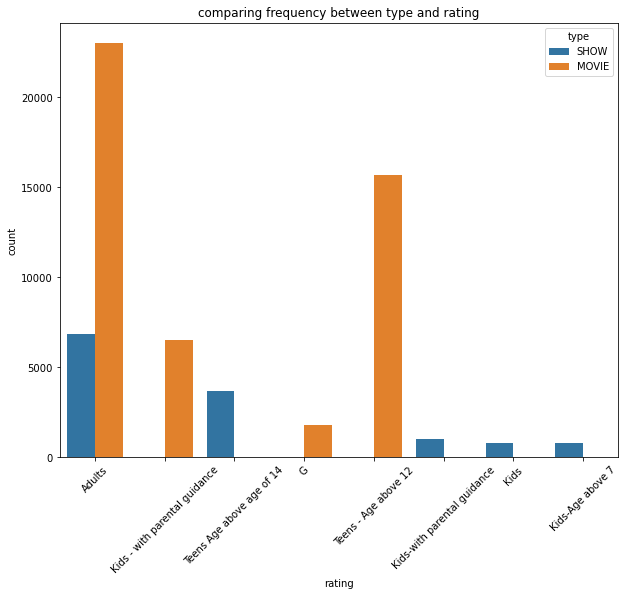

In [21]:
plt.figure(figsize=(10,8))
sns.countplot(x='rating',hue='type',data=df)
plt.title('comparing frequency between type and rating')
plt.xticks(rotation=45)
plt.show()

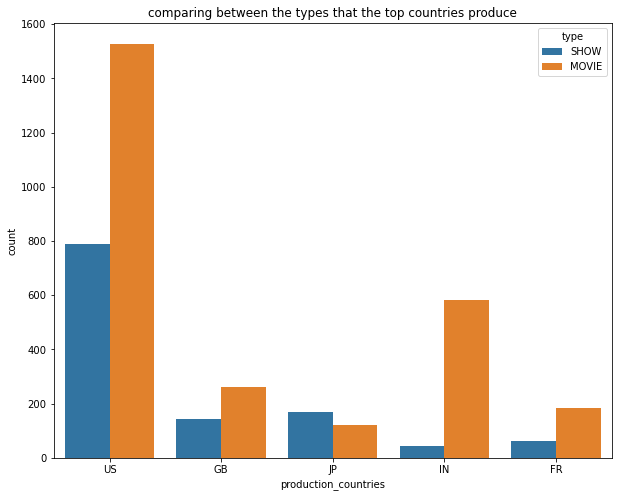

In [22]:
top_productive_countries=df[df['production_countries'].isin(df['production_countries'].value_counts()[0:5].index)].drop_duplicates(subset=['title', 'production_countries'])
plt.figure(figsize=(10,8))
sns.countplot(x='production_countries',hue='type',data=top_productive_countries)
plt.title('comparing between the types that the top countries produce')
plt.show()

### Highest rating TV show or Movies

In [23]:
dfCopy = df.drop_duplicates(subset=['title', 'type', 'rating']).copy()

# making 2 df one for tv show and another for movie with rating 
df_tv_show = dfCopy[dfCopy['type']=='SHOW'][['rating', 'type']].rename(columns={'type':'tv_show'})
df_movie = dfCopy[dfCopy['type']=='MOVIE'][['rating', 'type']].rename(columns={'type':'movie'})
df_movie = pd.DataFrame(df_movie.rating.value_counts()).reset_index().rename(columns={'index':'movie'})
df_movie
df_tv_show = pd.DataFrame(df_tv_show.rating.value_counts()).reset_index().rename(columns={'index':'tv_show'})
df_tv_show['rating_final'] = df_tv_show['rating'] 

# making rating column value negative
df_tv_show['rating'] *= -1

# create subplots
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_yaxes=True, horizontal_spacing=0)
# create bar plot for movies and tv shows
fig.append_trace(go.Bar(x=df_tv_show.rating, y=df_tv_show.tv_show, orientation='h', showlegend=True, 
                        text=df_tv_show.rating_final, name='TV Show', marker_color='#ffa600'), 1, 1)

fig.append_trace(go.Bar(x=df_movie.rating, y=df_movie.movie, orientation='h', showlegend=True, text=df_movie.rating,
                        name='Movie', marker_color='#bc5090'), 1, 2)
# styling the chart
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, categoryorder='total ascending', ticksuffix=' ', showline=False)
fig.update_traces(hovertemplate=None, marker=dict(line=dict(width=0)))
fig.update_layout(title='Which has the highest rating TV shows or Movies?',
                  margin=dict(t=80, b=0, l=70, r=40),
                  hovermode="y unified", 
                  xaxis_title=' ', yaxis_title='',
                  plot_bgcolor='#fff', paper_bgcolor='#fff',
                  title_font=dict(size=25, color='#003f5c', family="Open Sans, sans-serif"),
                  font=dict(color='#003f5c'),
                  legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="center", x=0.5),
                  hoverlabel=dict(bgcolor="#fff", font_size=13, font_family="Open Sans, sans-serif"))

fig.add_annotation(dict(x=0.9, y=0.5, ax=0, ay=0,
                    xref = "paper", yref = "paper",
                    text= '''<b>G</b>: Kids <br> <b>NC-17</b>: Adults <br> <b>NR</b>: NR <br> <b>PG-13</b>: Teens - Age above 12 <br> <b>PG</b>: Kids - with parental guidence <br> <b>R</b>: Adults <br> <b>TV-14</b>: Teens - Age above 14 <br> <b>TV-G</b>: Kids <br> <b>TV-MA</b>: Adults <br> <b>TV-PG</b>: Kids - with parental guidence <br> <b>TV-Y</b>: Kids <br> <b>TV-Y7</b>: Kids - Age above 7 <br><b>UR</b>: UR'''))


fig.show()

In [24]:
#Create the dataframe for genre
df_genre_s = titles[["title", "type", "genres"]].drop_duplicates()

#Type genre count
df_genre_count = df_genre_s.groupby(['genres', 'type'])["title"].count().reset_index().sort_values('title')
df_genre_count = df_genre_count.rename(columns = {"title": "movies_count"})

#Separating types by dataframe
df_g_m = df_genre_count.query("type == 'MOVIE'")
df_g_tvshow = df_genre_count.query("type == 'SHOW'")

#Create the subplots
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'bar'}, {'type':'bar'}]],
                   horizontal_spacing = .2)

#Create the chart
fig.add_trace(
    
    go.Bar(x= df_g_m['movies_count'], y= df_g_m['genres'], orientation = 'h',
           marker_color='#ffa600',  name="MOVIE", text = df_g_m['genres'],
           showlegend=False,
           textposition='auto'),
    row=1, col=1)

fig.add_trace(
    
    go.Bar(x= df_g_tvshow['movies_count'], y= df_g_tvshow['genres'], orientation = 'h',
           marker_color = '#bc5090', name = "SHOW", text = df_g_tvshow['genres'],
           showlegend=False,
           textposition='auto'),
    row=1, col=2)

# styling the chart
fig.update_traces(hovertemplate=None, marker=dict(line=dict(width=0)))
fig.update_yaxes(visible=False, categoryorder='total ascending')

fig.update_layout(title = 'Most preferred Genre for TV Shows and Movies',
                  height=600, width=800,
                  margin=dict(t=70, b=20, l=70, r=40),
                  hovermode="y unified", 
                  plot_bgcolor='#fff', paper_bgcolor='#fff',
                  title_font=dict(size=30, color='#003f5c', family="Open Sans, sans-serif"),
                  font=dict(color='#003f5c', size=10))

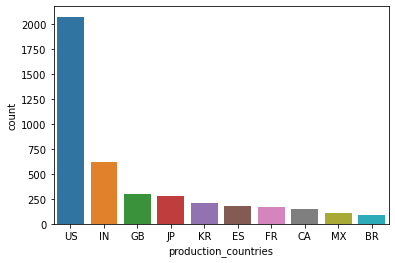

In [25]:
sns.countplot(df.drop_duplicates(subset='title').production_countries, order=df.drop_duplicates(subset='title').production_countries.value_counts().iloc[:10].index);

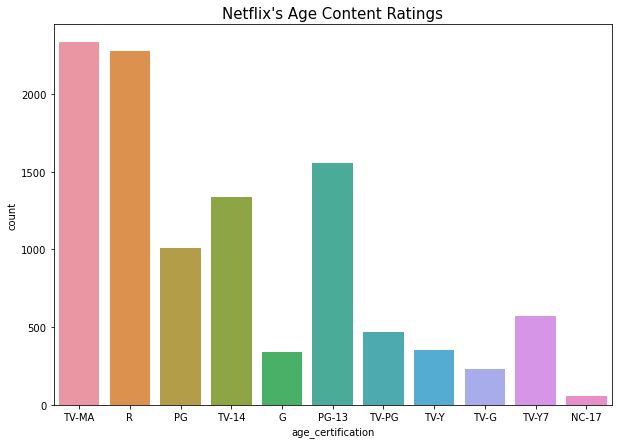

In [26]:
plt.figure(figsize=(10,7))
sns.countplot(titles['age_certification'])
plt.title("Netflix's Age Content Ratings",fontsize=15)
plt.show()

In [27]:
#Create the dataframe for TV Shows
showsDf = df[df["type"] == "SHOW"].drop_duplicates(subset='title')
released = "release_year"

showsDf = showsDf[released].value_counts().reset_index().rename(columns = {released : "count", "index" : released})
showsDf['percent'] = showsDf['count'].apply(lambda x : 100 * x / sum(showsDf['count']))
showsDf = showsDf.sort_values(released)

#Create the chart
fig2 = go.Figure(go.Waterfall(
    name = "SHOW", orientation = "v", 
    x = ["2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021"],
    textposition = "auto",
    text = ["1", "2", "1", "13", "3", "5", "5", "26", "176", "349", "427", "592", "595", "505"],
    y = [1, 2, -1, 13, -3, 6, 14, 48, 204, 743, 1121, 1366, -1228, -84],
    connector = {"line":{"color":"#bc5090"}},
    increasing = {"marker":{"color":"#bc5090"}},
    decreasing = {"marker":{"color":"#ffa600"}},

))

# styling the chart
fig2.update_xaxes(showgrid=False)
fig2.update_yaxes(showgrid=False, visible=False)
fig2.update_traces(hovertemplate=None)
fig2.update_layout(title='TV Show Realeases Over The Year', height=350,
                   margin=dict(t=80, b=20, l=50, r=50),
                   hovermode="x unified",
                   xaxis_title=' ', yaxis_title=" ",
                   plot_bgcolor='#fff', paper_bgcolor='#fff',
                   title_font=dict(size=25, color='#003f5c', family="Open Sans, sans-serif"),
                   font=dict(color='#003f5c'))

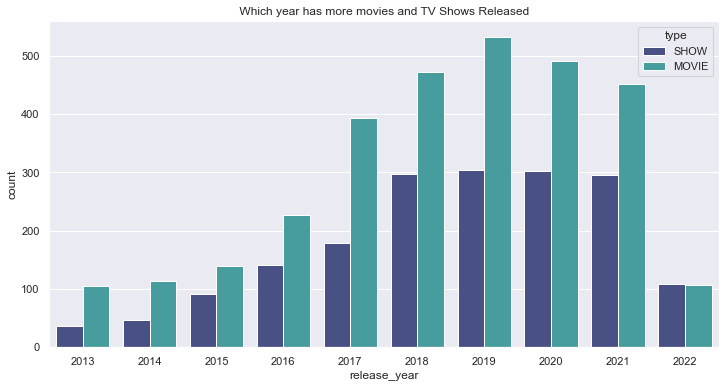

In [28]:
year_df = df.drop_duplicates(subset='title') 
plt.figure(figsize=(12 ,6 ))
sns.set(style='darkgrid')
sns.countplot(data = year_df , x = year_df['release_year'] ,hue=year_df['type'],palette='mako', order=year_df['release_year'].value_counts().index[0:10].sort_values())
plt.title(' Which year has more movies and TV Shows Released ') ; 

Insights:

1. Movies were the most released types on Netflix until the year 2021
2. There was strong growth in new content launches from 2016 to 2019, but this growth was held back by the Covid-19 pandemic.
3. The United States and India are responsible for the largest number of content released.
4. The United States and India are responsible for the largest number of content released. The number of American releases is much higher than in other countries, due to the strength of its film industry.

# Network Analysis

In [29]:
titles = pd.read_csv("Titles.csv")
titles = titles[~titles["title"].isnull()]
credits = pd.read_csv("Credits.csv")
df = pd.merge(titles,credits, on='id', how='left')

In [30]:
df_Show = df[df['type'] == 'SHOW']
df_Movies = df[df['type'] == 'MOVIE']

In [31]:
cast_Movies_df = pd.DataFrame(df_Movies[(df_Movies['role'] == 'ACTOR')]['name'].value_counts()).reset_index().rename(columns={'index':'cast', 
                                                                                                             'name':'Frequency (Movies)'})

cast_Show_df = pd.DataFrame(df_Show[(df_Show['role'] == 'ACTOR')]['name'].value_counts()).reset_index().rename(columns={'index':'cast', 
                                                                                                             'name':'Frequency (TV shows)'})

In [32]:
def calc_degs(df):
    cast = pd.DataFrame(df.groupby('title')['name'].apply(list).values)
    
    combinations_list = []
    for i in cast[0].iteritems():
        combinations_list.append(list(itertools.combinations(i[1], 2)))

    flat_list = [item for sublist in combinations_list for item in sublist]
    
    G=nx.Graph()
    G.add_edges_from(flat_list)
  
    degrees = pd.DataFrame.from_dict(G.degree).rename(columns = {0:'cast', 1:'degree'})
    
    return G, degrees

In [33]:
df_list = [df_Movies, df_Show]
cast_dfs = [cast_Movies_df, cast_Show_df]
df_results = []
graph = []
for index, df in enumerate(df_list):
    G, degrees = calc_degs(df)
    results_ = cast_dfs[index].merge(degrees, left_on = 'cast', right_on = 'cast')
    results_ = results_.sort_values('degree', ascending = False).reset_index(drop = 'True')
    
    df_results.append(results_)
    graph.append(G)

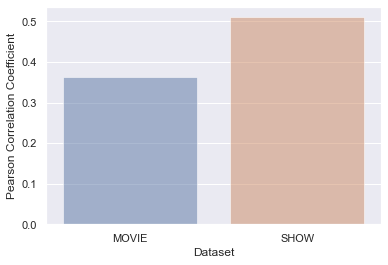

In [34]:
graph_vals = ['MOVIE','SHOW']
corr = []
for index, g in enumerate(graph):
    r = nx.degree_pearson_correlation_coefficient(g)
    corr.append(r)
    
corr_df = pd.DataFrame({'Dataset':graph_vals, 'Pearson Correlation Coefficient':corr})

g = sns.barplot(x = 'Dataset', y = 'Pearson Correlation Coefficient', data = corr_df,  alpha=0.5)

In [35]:
def get_actor_tuple(df, particular_actor_index):
    particular_actor = df.iloc[particular_actor_index]['cast']
    actor_list = list(df[df.cast != particular_actor]['cast'])

    tuple_list = []
    for actor in actor_list:
        tuple_list.append((particular_actor, actor))

    paths = {}
    for nodes in tuple_list:
        try:
            paths[nodes] = nx.shortest_path_length(graph[0], *nodes)
        except:
            pass
        
    return paths

In [36]:
def plot_graph_path(paths, path_type, color):
    if path_type == 'min':
        path = min(paths.items(), key=lambda x: x[1])[0]
    else:
        path = max(paths.items(), key=lambda x: x[1])[0]
        
    induced_path = nx.shortest_path(graph[0], *path)

    sG = nx.subgraph(graph[0], induced_path)

    pos = nx.spring_layout(sG, scale=20, k=3/np.sqrt(graph[0].order()))
    nx.draw(sG, pos, node_color=color, 
            with_labels=True, 
            node_size=1500,
            arrowsize=20)

<a id="B5"></a>
# Shortest path between actors
Here I look at the "top" actor, which is Sandler. Changing the last index would get the connection for a different actor.

The shortest path for the set of all actors with sandler and Adam

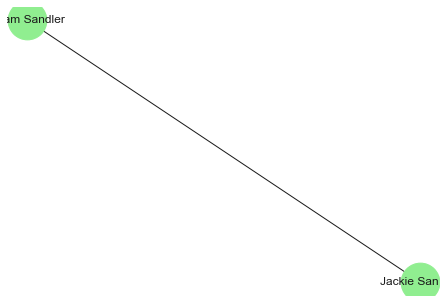

In [37]:
paths_movie = get_actor_tuple(df_results[0], 0)
plot_graph_path(paths_movie, 'min', 'lightgreen')

<a id="B6"></a>
# Longest path
The longest path between Kholoud and Sandler is much longer!

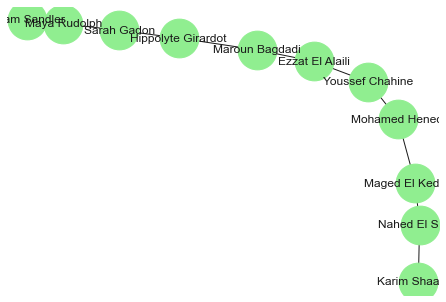

In [38]:
plot_graph_path(paths_movie, 'max', 'lightgreen')

<a id="B7"></a>
# Shortest path for TV Shows
Again I choose the top actor and compare the graph for all other actors.

The closest connection is Junichi.

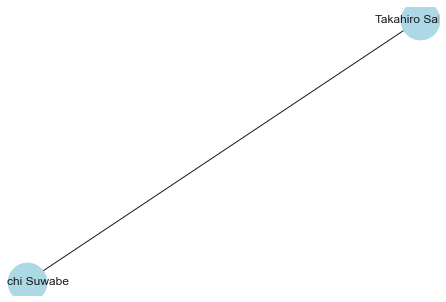

In [39]:
paths_tv = get_actor_tuple(df_results[1], 0)
plot_graph_path(paths_tv, 'min', 'lightblue')

<a id="B8"></a>
# Longest path for TV Shows
The longest path is Sakurai and Sawsan

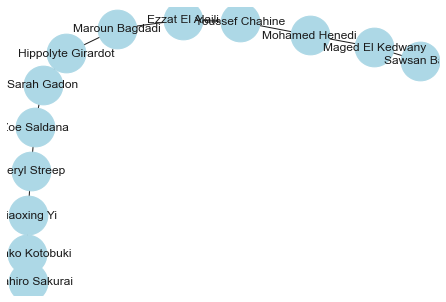

In [40]:
plot_graph_path(paths_tv, 'max', 'lightblue')

In [41]:
def plot_subgraph(graph, graph_index, color, dorandom):
    subgraphs = [graph.subgraph(c) for c in nx.connected_components(graph)]

    subgraphslist = []
    for subgraph in subgraphs:
        if subgraph.number_of_nodes() > 10 and subgraph.number_of_nodes() <= 50:
            subgraphslist.append(subgraph)
    
    if dorandom: graph_index = random.sample(range(len(subgraphslist)),1)[0]
    
    nx.draw(subgraphslist[graph_index], node_color=color, 
            with_labels=True, 
            node_size=1500,
            arrowsize=20)

<a id="B9"></a>
# Viewing subgraphs for Movies
I break down the graph into subgraphs, and choose only those with more than 10 nodes and less than or equal to 50 nodes.

This is a randomised viewer of the subgraphs.

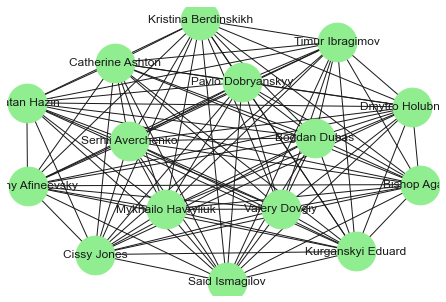

In [42]:
plot_subgraph(graph[0],_,'lightgreen',True)

<a id="B10"></a>
# Example of interesting subgraph
This is a densely connected subgraph - there are others and functions can be used to find these.

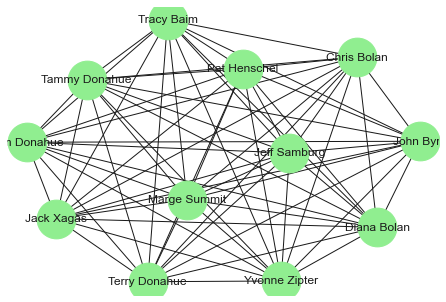

In [43]:
plot_subgraph(graph[0],3,'lightgreen', False)

<a id="B11"></a>
#  Viewing subgraphs for TV Shows
This is again a randomised viewer of the subgraphs for TV shows.

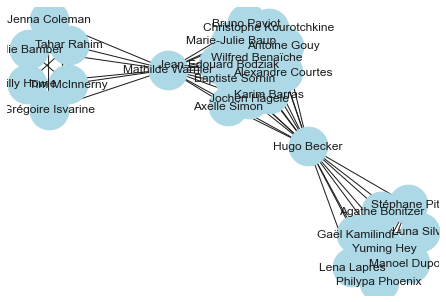

In [44]:
plot_subgraph(graph[1],_,'lightblue',True)

<a id="B12"></a>
# Viewing an interesting subgraph
I chose this subgraph as an interesting example of a more dense subgraph.

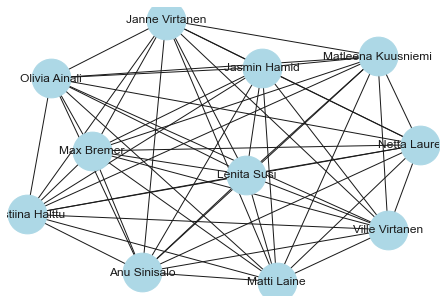

In [45]:
plot_subgraph(graph[1],23,'lightblue',False)

In [46]:
def plot_egograph(type_, graph_index):
    if type_ == 'Movies':
        actor = df_results[0].iloc[graph_index]['cast']
        egograph = nx.ego_graph(graph[0], n = actor)
        color = 'lightgreen'
    else:
        actor = df_results[1].iloc[graph_index]['cast']
        egograph = nx.ego_graph(graph[1], n = actor)
        color = 'lightblue'        
    
    r = nx.degree_pearson_correlation_coefficient(egograph)

    graph_ = nx.draw(egograph, node_color=color, 
                with_labels=True, 
                node_size=1500,
                arrowsize=20)
    
    return graph_, r, actor

<a id="B13"></a>
# Egographs for Movies
The egograph looks at the subgraph centred on an actor within a particular radius. I use the default of radius = 1.

nan
Umeji Sasaki


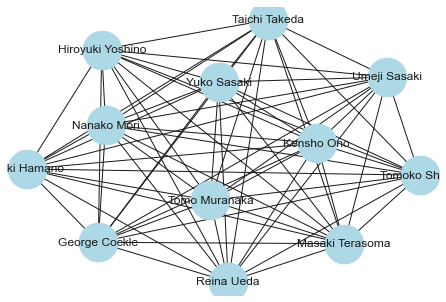

In [47]:
egograph, r, actor = plot_egograph('MOVIES', 5000)

print(r)
print(actor)

<a id="B14"></a>
# Viewing egograph for midway actor in Movies
The subgraph is as below for the actor middling in the list of all actors (ordered by degree of nodes).

nan
Paul Solotaroff


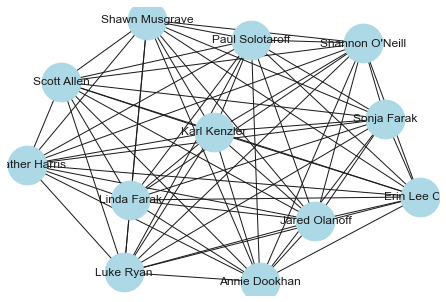

In [48]:
index = int(np.round(df_results[1].shape[0]/2,2))

egograph, r, actor = plot_egograph('MOVIES', index)

print(r)
print(actor)

<a id="B15"></a>
# Egograph for TV Shows


-0.002380952380952375
Zoe Saldana


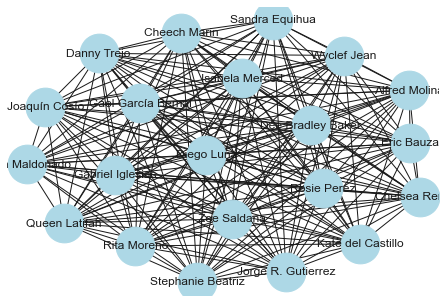

In [49]:
egograph, r, actor = plot_egograph('SHOW', 2000)

print(r)
print(actor)

<a id="B16"></a>
# Viewing egograph for midway actor in TV shows
The subgraph is as below for the actor middling in the list of all actors (ordered by degree of nodes).

nan
Paul Solotaroff


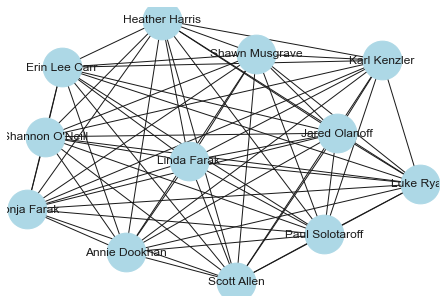

In [50]:
index = int(np.round(df_results[1].shape[0]/2,2))

egograph, r, actor = plot_egograph('SHOW', index)

print(r)
print(actor)

# top 10 movies by imdb

In [51]:
df_credits = pd.read_csv('Credits.csv')
df_titles = pd.read_csv('Titles.csv')

In [52]:
id_uniques = df_credits['id'].unique()
ids = df_credits['id']
roles = df_credits['role']
names = df_credits['name']

# List save actors and directors
actors = []
directors = []

start = 0

for id_unique in id_uniques:
    act = []
    dir = []
    for i in range(start, len(ids)):
        if (ids[i] == id_unique):
            if roles[i] == "ACTOR":
                act.append(names[i])
            elif roles[i] == "DIRECTOR":
                dir.append(names[i])
        else:
            start = i
            break
    actors.append(act)
    directors.append(dir)
data = {'id': id_uniques, 'actors': actors, 'directors': directors}
new_df = pd.DataFrame(data = data)

In [53]:
df_cleaned = df_titles.merge(new_df, how='inner', on='id')
df_cleaned['genres'] = df_cleaned['genres'].apply(ast.literal_eval)

C= df_cleaned['imdb_score'].mean()
m= df_cleaned['imdb_votes'].quantile(0.9)
q_movies = df_cleaned.copy().loc[df_cleaned['imdb_votes'] >= m]


def weighted_rating(x, m=m, C=C):
    v = x['imdb_votes']
    R = x['imdb_score']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)


q_movies[['title', 'imdb_votes', 'imdb_score', 'score']].head(10)

,title,imdb_votes,imdb_score,score
240,Breaking Bad,1727694.0,9.5,9.414313
256,Avatar: The Last Airbender,297336.0,9.3,8.892175
257,Inception,2268288.0,8.8,8.749761
107,Forrest Gump,1994599.0,8.8,8.743040
873,Attack on Titan,325381.0,9.0,8.663388
267,DEATH NOTE,302147.0,9.0,8.641260
1155,Stranger Things,989090.0,8.7,8.592919
872,Peaky Blinders,485506.0,8.8,8.582908
46,Seinfeld,302700.0,8.9,8.556309
1153,Better Call Saul,404920.0,8.8,8.544560


Text(0.5, 1.0, 'Popular Movies')

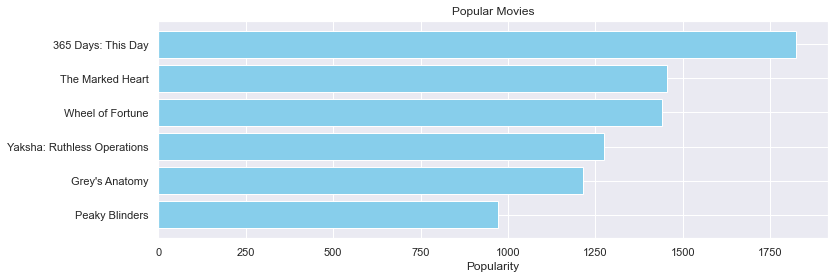

In [54]:
pop= df_cleaned.sort_values('tmdb_popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['tmdb_popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

# Recommendation based on Genres and Descriptions

In [55]:
df = pd.read_csv("Titles.csv")
credits_df = pd.read_csv("Credits.csv")

In [56]:
df["director"] = pd.merge(
    df, credits_df[credits_df["role"] == "DIRECTOR"], on="id", how="left"
)["name"].replace(np.nan, None)

df["actors"] = pd.merge(
    df,
    pd.merge(df, credits_df[credits_df["role"] == "ACTOR"], on="id", how="left")
    .groupby("id")["name"]
    .apply(lambda x: x.tolist() if x is not np.nan else None),
    on="id",
    how="left",
)["name"].apply(lambda x: ["" if i is np.nan else str(i) for i in x])

df["actors"] = df["actors"].replace(np.nan, "")

In [57]:
df["overview"] = (
    (
        df["title"].astype(str)
        + " "
        + df["description"].astype(str)
        + " "
        + df["genres"].apply(lambda x: " ".join(x))
        + " "
        + df["director"].astype(str)
        + " "
        + df["actors"].apply(lambda x: "" if x is [] else " ".join(x))
    )
    .str.lower()
    .str.replace("\n", " ")
    .str.replace("—", "")
)

In [58]:
count = CountVectorizer(stop_words="english", ngram_range=(1, 5))
count_matrix = count.fit_transform(df["overview"])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
indices = pd.Series(df.index, index=df["title"])
count = CountVectorizer(stop_words="english", ngram_range=(1, 5))
count_matrix = count.fit_transform(df["overview"])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
indices = pd.Series(df.index, index=df["title"])

In [59]:
def get_recommendations(title, cosine_sim, top_k=5):

    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:20]
    movie_indices = [i[0] for i in sim_scores if i[0] != idx]

    return (
        df.iloc[movie_indices]
        .sort_values(["imdb_votes", "imdb_score"], ascending=False)[
            ["title", "description", "genres", "imdb_score"]
        ]
        .reset_index(drop=True)
        .head(top_k)
    )

In [60]:
get_recommendations("3 Idiots", cosine_sim=cosine_sim, top_k=5)

,title,description,genres,imdb_score
0,PK,"A stranger in the city asks questions no one has asked before. Known only by his initials, the man's innocent questions and childlike curiosity take him on a journey of love, laughter and letting go.","['comedy', 'drama', 'romance', 'fantasy', 'scifi']",8.2
1,Rang De Basanti,"After a group of friends graduate from Delhi University, they listlessly haunt their old campus, until a British filmmaker casts them in a film she's making about freedom fighters under British rule. Although the group is largely apolitical, the tragic death of a friend owing to local government corruption awakens their patriotism. Inspired by the freedom fighters they represent in the film, the friends collectively decide to avenge the killing.","['comedy', 'drama', 'history', 'crime']",8.1
2,Dil Chahta Hai,"Three inseparable childhood friends are just out of college. Nothing comes between them - until they each fall in love, and their wildly different approaches to relationships creates tension.","['drama', 'comedy', 'romance']",8.1
3,Jab We Met,A depressed wealthy businessman and a spunky and care-free young woman embark on an unexpected journey that changes their lives.,"['comedy', 'drama', 'romance']",7.9
4,Kabhi Khushi Kabhie Gham,"Rahul, the adoptive son of business magnate Yash Raichand, feels eternal gratitude to his father for rescuing him from a life of poverty. Yet, when Yash forbids his love of poor Anjali, Rahul marries her and moves to London with new wife and sister-in-law, breaking the heart of his mother. Ten years later, Rahul's younger brother comes to London intent on brokering peace between father and son.","['drama', 'romance']",7.4


# Conversation Analysis

In [61]:
titles = pd.read_csv("Titles.csv")
credits = pd.read_csv("Credits.csv")

In [62]:
conversation_data = pd.read_csv("conversation_data.csv",encoding = "ISO-8859-1")

In [63]:
conversation_data.head()

,UniversalMessageId,SocialNetwork,Sednder iD,Message,MessageType,Retweets
0,TWITTER_4_1223986940472713217,TWITTER,Sender 32,Our new @AgentsDiscovery app at 10 #ColoradoStateParks is helping people connect with nature in a new way. Check it out!\n\ndenver.cbslocal.com/2020/01/31/col,Twitter Mention,1
1,TWITTER_4_1313541242723106819,TWITTER,Sender 47,Back in the driver's seat LIVE on @Twitch ! Join me as I put my real life racing skills to the test in the virtual world --> Twitch.tv/StarGirlRacing . See you there!,Twitter Mention,2
2,TWITTER_4_1315813219446018048,TWITTER,Sender 53,"Are you a female entrepreneur looking for feedback on, or funding for, your business? Register for the NJ chapter of @GoldenSeeds virtual office hours on Oct. 21. You'll get to network w/ the Golden Seeds community & chat 1-on-1 with seasoned investors. events.r20.constantcontact.com/register/event https://t.co/BsnhX6FCJx",Twitter Mention,5
3,TWITTER_2_1314488550424023041,TWITTER,Sender 88,?? EXCITING ANNOUNCEMENT! ??\n?? Save the date and grab your popcorn! ??\n\nAt 1pm on Monday 12th October the first EVER film-only version of IncludFEST will premiere! We'll post the link on socials ??\n\nCheck out the full programme ?? Thanks to all who made this a (virtual) reality! pic.twitter.com/TfUsd8NGVV,Twitter Update,5
4,TWITTER_2_1220663990042361856,TWITTER,Sender 110,The effects of human-caused global warming are becoming more apparent year after year - #VirtualReality might be the solution we need to change people's attitudes\narpost.co/2020/01/20/can,Twitter Update,1


In [64]:
titles["genres"]=titles["genres"].apply(u.repair_array_bound_categories)
titles = titles.explode('genres').drop_duplicates()

In [65]:
genres = list(titles[titles.type=='MOVIE'].genres.str.lower().dropna().unique())
related_genres_movies = titles[titles.genres.isin(genres)].drop_duplicates()
movies  = list(related_genres_movies.title.str.lower().dropna().unique())

In [66]:
def hashtag_extractor(sample_tweet):
    hash_tags = []
    for i in sample_tweet['Message'].split(' '):
        if len(i) >0 and i[0] == '#':
            hash_tags.append(i)
    return hash_tags

In [67]:
def tweet_text_extractor(sample_tweet):
    """
    Remove the hashtag and http links form the tweets
    returns : the clean text
    """
    tweet_text = []
    for i in sample_tweet['Message'].split('\n'):
        for j in i.split(' '):
            if '#'in j:
                continue
            elif 'http' in j:
                continue
            else:
                tweet_text.append(j)
    tweet_text = list(filter(None, tweet_text))
    tweet_text =' '.join(tweet_text)
    return tweet_text

In [68]:
conversation_data['tweet_text'] = conversation_data.apply(lambda sample_tweet: tweet_text_extractor(sample_tweet),axis=1)

In [69]:
def movie_tweet(sample_tweet):
    """
    Takes the tweet text as input.
    Returns : List of bad words found in the tweet.
    """
    sample_tweet = sample_tweet['tweet_text'].lower()
    movie_words_found = []
    for j in movies:
        if j in sample_tweet:
            movie_words_found.append(j)
    return movie_words_found

In [70]:
conversation_data['is_movie_tweet']  = conversation_data.apply(lambda sample_tweet: movie_tweet(sample_tweet),axis=1)

In [71]:
movie_conversations = conversation_data[conversation_data['is_movie_tweet'].apply(lambda x : len(x)) > 0]

In [72]:
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'),additional)

In [73]:
movie_conversations['processed_text'] = movie_conversations['Message'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z \t])',' ')\
          .str.replace(' +',' ')\
          .apply(lambda x: [i for i in x.split() if not i in swords])

In [74]:
ps = PorterStemmer()
movie_conversations['stemmed'] = movie_conversations['processed_text'].apply(lambda x: [ps.stem(i) for i in x if i != ''])

In [75]:
sia = vd.SentimentIntensityAnalyzer()
movie_conversations['sentiment_score'] = movie_conversations['processed_text'].apply(lambda x: sum([ sia.polarity_scores(i)['compound'] for i in word_tokenize( ' '.join(x) )]) )

In [76]:
sent_clasification = pd.cut(movie_conversations['sentiment_score'],\
          [-3,-1.2, 0, 1.2 , 3],\
          right=True,\
          include_lowest=True,\
          labels=['strongly negative', 'negative', 'positive', 'strongly positive'])

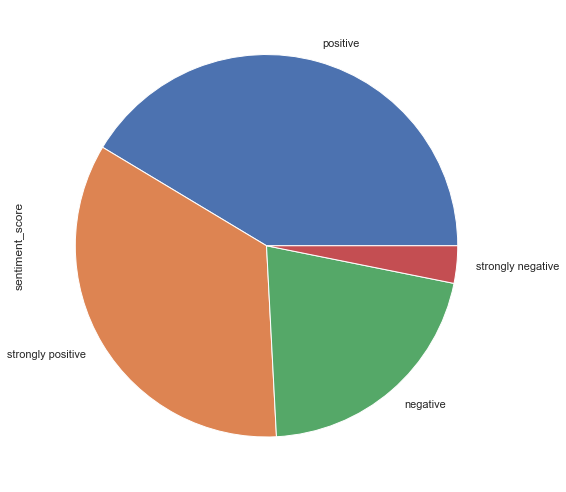

In [77]:
plt.figure(figsize=(10,7)) #make it smaller this time
sent_clasification.value_counts().plot(kind='pie')
plt.grid(False)
plt.tight_layout()

# Conversation Trend Analysis

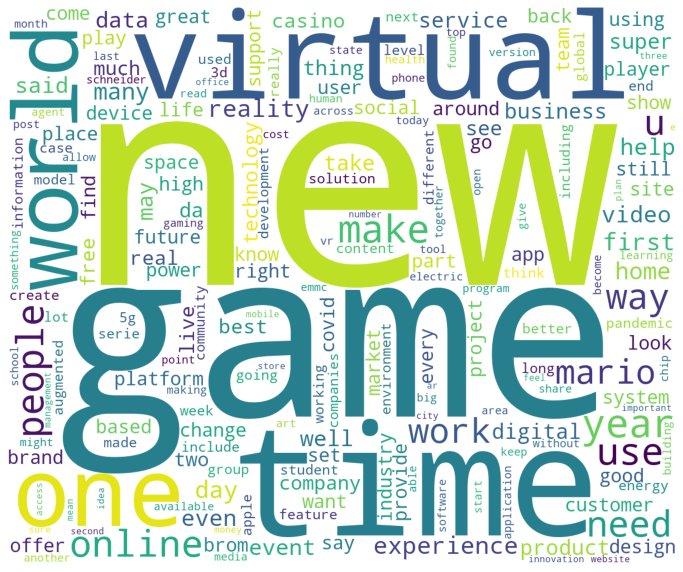

In [78]:
from wordcloud import WordCloud, STOPWORDS
bigstring = movie_conversations['processed_text'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
plt.figure(figsize=(12,12))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)

In [79]:
count = 0
top_ten = {}
for k,v in wordcloud.words_.items():
    count += 1
    if count < 10 and k not in  top_ten:
        top_ten.update({k:v})
top_ten

{'new': 1.0,
 'game': 0.7866929345392675,
 'time': 0.7832005014775678,
 'virtual': 0.7738873466463687,
 'one': 0.7369033760186263,
 'world': 0.6236231754275992,
 'year': 0.52332766186084,
 'make': 0.5141936061610101,
 'use': 0.4772096355332677}

In [80]:
print('Word CLoud for Genres')
word_cloud =  WordCloud(
    width=600,
    height=600,
    max_words=1000000,
    background_color="white",
    colormap="Set2",
    
).generate(str(" ".join(genres)))

fig = go.Figure()
fig.update_layout(
    width=600,
    height=600,
    xaxis_showticklabels=False,
    yaxis_showticklabels=False,
)
fig.add_trace(go.Image(z=word_cloud))
fig.show()

Word CLoud for Genres


In [81]:
import re
hashtags = movie_conversations['Message'].apply(lambda x: pd.value_counts(re.findall('(#\w+)', x.lower() )))\
                     .sum(axis=0)\
                     .to_frame()\
                     .reset_index()\
                     .sort_values(by=0,ascending=False)
hashtags.columns = ['hashtag','occurences']

In [82]:
hashtags.head()

,hashtag,occurences
1569,#virtualreality,160.0
3,#1,123.0
1585,#vr,108.0
1256,#schneiderelectric,99.0
1257,#schneidernews,99.0


In [83]:
import plotly.express as px
fig = px.bar(hashtags.head(10), x='hashtag', y='occurences')
fig.show()

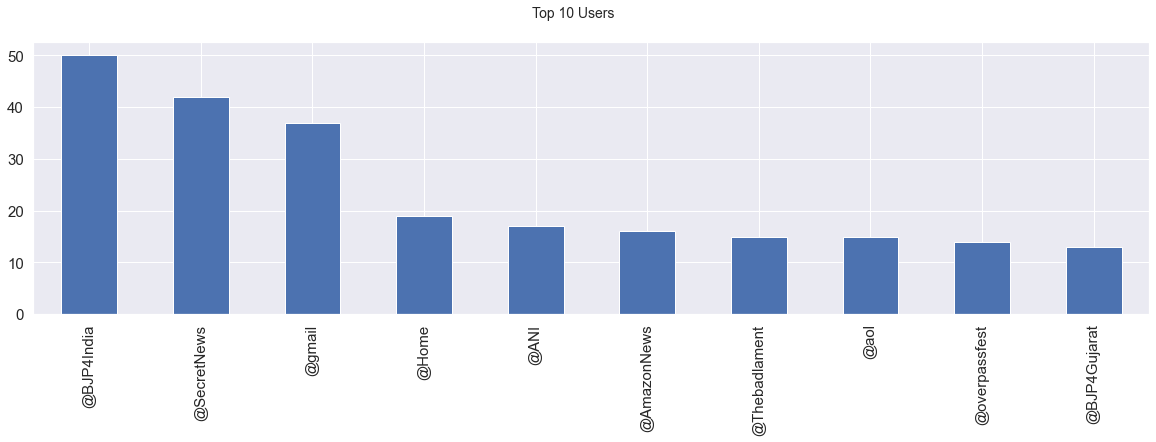

In [84]:
plt.grid(False)
# plt.tight_layout()
plt.suptitle('Top 10 Users', fontsize=14)
movie_conversations['Message'].str\
          .findall('(@[A-Za-z0-9]+)')\
          .apply(lambda x: pd.value_counts(x))\
          .sum(axis=0)\
          .sort_values(ascending=False)[:10]\
          .plot(kind='bar',figsize=(20,5))
plt.tick_params(axis='both', labelsize=15)


In [85]:
import re
words = movie_conversations['processed_text'].dropna()\
                            .apply(lambda y: pd.value_counts(re.findall('([\s]\w+[\s])',' '.join(y))))\
                            .sum(axis=0)\
                            .to_frame()\
                            .reset_index()\
                            .sort_values(by=0,ascending=False)
words.columns = ['word','occurences']

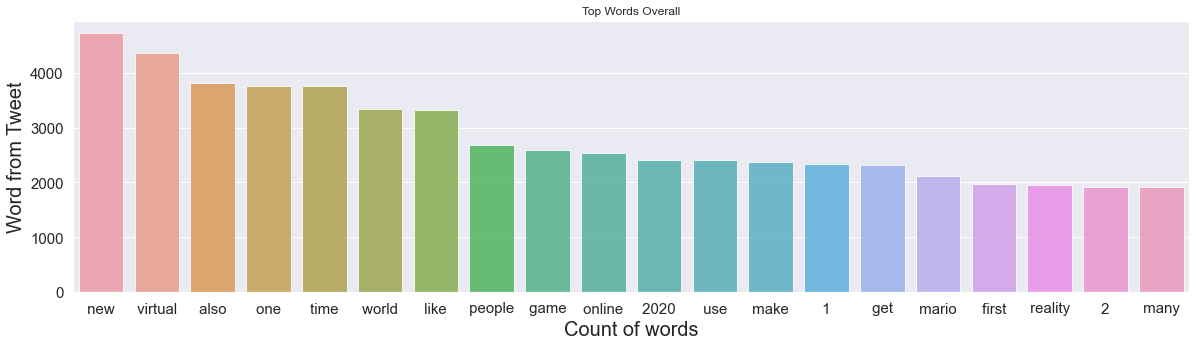

In [86]:
#plots the top 20 used words
words = words[:20]
plt.figure(figsize=(20,5))
sns.barplot(words.word, words.occurences, alpha=0.8)
plt.title('Top Words Overall')
plt.xlabel('Count of words', fontsize=20)
plt.ylabel('Word from Tweet', fontsize=20)
plt.tick_params(axis='both', labelsize=15)
plt.show()

In [87]:
from nltk import bigrams
bigramseries = pd.Series([word for sublist in movie_conversations['processed_text'].dropna()\
                    .apply(lambda x: [i for i in bigrams(x)])\
                    .tolist() for word in sublist])\
                    .value_counts()

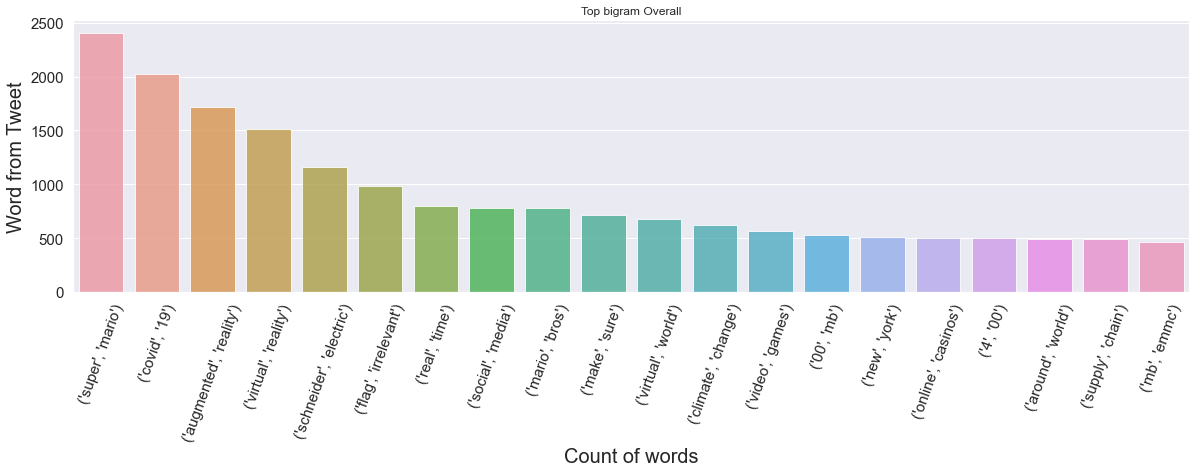

In [88]:
#plots the top 20 used words
bigram = pd.DataFrame(bigramseries).reset_index().head(20)
plt.figure(figsize=(20,5))
sns.barplot(bigram['index'], bigram[0], alpha=0.8)
plt.title('Top bigram Overall')
plt.xlabel('Count of words', fontsize=20)
plt.ylabel('Word from Tweet', fontsize=20)
plt.tick_params(axis='both', labelsize=15)
plt.xticks(rotation=70)
plt.show()